# Particle simulation vs Langevin model

In [1]:
using Revise

In [2]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist

In [3]:
using DifferentialEquations, Distributions, LaTeXStrings, ProgressMeter

In [4]:
using Plots
# plotly()
gr()


Plots.GRBackend()

## Fixed Density

First we compare the particle simulation with the simulations of the Langevin equation (and some analytical results from it) for a fixed population size.

When comparing the two we must take care to ensure both approaches are modeling the same system. In particular, a particle modeled by the Langevin equation has its future speed distribution initially determined by the energy of the system, as it is parameterized by $D/\gamma$ (see equation (3) in document) which can be equated to the average energy per particle $\left< E \right>$ (4); however in the simulation particles are introduced into the system with a speed rather than an energy. If the simulation is initiated with all particles having the same speed -- which is convenient to ensure the system evolves to the predetermined equilibrium, as opposed to drawing their speeds from the desired distribution in which case the system energy becomes a random variable -- we must ensure the average energy matches that of the Langevin particle. We know that
\begin{equation}
    \left< E \right> = \frac{\left< v^2 \right>}{2}
\end{equation}
thus using $\left< v_0^2 \right> = \left< s_0^2 \right> = s_0^2$ (since all particles have the same speed initially) we know that the initial particle speed and the average energy per particle are related through
\begin{align}
    s_0 = \sqrt{2\left< E \right>} \\
    \left< E \right> = \frac{s_0^2}{2}
\end{align}
Note that as the system evolves the particle speeds should become distributed according to the Rayleigh distribution, and the average speed becomes
\begin{equation}
    \left< s \right> = \sqrt{E} \sqrt{\frac{\pi}{2}}
\end{equation}

### Parameters for simulation

In [5]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
end

extendParams! (generic function with 1 method)

In [6]:
arenaParams = 
    Dict(
        "n0"=>500,
        "evolveTime"=>1500,
        "timeStep"=> 0.1,
        "bounds"=>((0.,10.),(0.,10.)), 
        "radius"=>0.08, 
        "speed"=>0.02
    )

extendParams!(arenaParams)

waitTime = 500
timeSteps = arenaParams["timeStep"]:arenaParams["timeStep"]:arenaParams["evolveTime"]

display(arenaParams)

function fillDensity(arenaParams)  
    xperiod = abs(arenaParams["bounds"][1][2] - arenaParams["bounds"][1][1])
    yperiod = abs(arenaParams["bounds"][2][2] - arenaParams["bounds"][2][1])
    n0 = arenaParams["n0"]
    r = arenaParams["radius"]
    V = xperiod*yperiod
    fillDens = n0*π*r^2 / V
    return fillDens
end

println("surface covered: ", fillDensity(arenaParams))

Dict{String,Any} with 8 entries:
  "volume"     => 100.0
  "evolveTime" => 1500
  "speed"      => 0.02
  "radius"     => 0.08
  "timeStep"   => 0.1
  "bounds"     => ((0.0, 10.0), (0.0, 10.0))
  "bperiod"    => [10.0, 10.0]
  "n0"         => 500

surface covered: 0.10053096491487339


In [7]:
thermVals = Theorist.thermalValues(arenaParams)


Dict{Any,Any} with 8 entries:
  "γ"         => 0.0401061
  "ρ"         => 0.100531
  "σc"        => 0.32
  "D"         => 8.02121e-6
  "l"         => 0.441942
  "E"         => 0.0002
  "DiffCoeff" => 0.00498678
  "n"         => 5.0

### Simulations

run a particle simulation:

In [8]:
arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID = 
    BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], arenaParams["timeStep"], arenaParams; 
        verbose=true);

Building arena...
93 overlaps found.
Removing center of mass drift...
Arena with 500 cells built.
::::: Initial total kinetic energy: 0.10000000000000002


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

In [9]:
println("energy per cell: ",
        BParts.kineticEnergy(arena) / arenaParams["n0"]
    )
println(BParts.avParticleEnergy(arena.cellsList))
println(BParts.comVel(arena.cellsList))
println(length(arena.cellsList))

energy per cell: 0.00020000000000000015
0.00020000000000000015
[-1.5404344466674047e-18, 2.220446049250313e-19]
500


Run an ensemble of Langevin equations:

In [10]:
@time langevinEnsemble = Theorist.runLangevinSims(1000, arenaParams);

Energy: 0.0002
 44.769576 seconds (416.09 M allocations: 14.552 GiB, 9.07% gc time)


### Analysis

Speed distributions:

For a well mixed population the particle speeds are predicted to be Rayleigh distributed with shape parameter $\sigma = \sqrt{E}$ where $E$ is the average particle energie.

In [11]:
evolveTime = arenaParams["evolveTime"]
speedPar_t_id = BParts.speedCalc(vel_t_dim_id)
speedLan_t_id = Theorist.speedCalc(langevinEnsemble, 1:evolveTime)
rDistPred = Rayleigh( sqrt(thermVals["E"]) );


In [12]:
speedMeanPar = mean(speedPar_t_id[500:end,:])
speedMeanLan = mean(speedLan_t_id)
speedMeanTheory = √(thermVals["E"])*sqrt(π/2)

println(speedMeanLan)
println(speedMeanPar)
println(speedMeanTheory)

0.017687720897149175
0.017666013179030274
0.017724538509055157


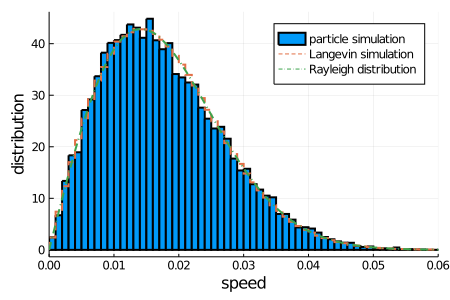

In [13]:
p1 =
histogram(vec(speedPar_t_id[waitTime:end,:,:]), bins=100, normalize=true, label="particle simulation", 
    size=(450,300), dpi=100, linewidth=2)
histogram!(vec(speedLan_t_id), bins=100, normalize=true, 
    label="Langevin simulation",
    linewidth=2,
    linestyle=:dash)
plot!(range(0,0.10, length=100), pdf.(rDistPred, range(0,0.10, length=100)), 
    linestyle=:dashdot, linewidth=2, label="Rayleigh distribution")
xlims!(0,0.06)
xlabel!("speed")
ylabel!("distribution")
display(p1)

# savefig(p1, "../figures/fixedDensity_speedDist.pdf")


The velocity autocorrelation is expected to be described by
\begin{equation}
    \left< v(t)v(t+\tau) \right> = 2E e^{-\gamma \tau}
\end{equation}
where $\gamma$ is determined by the density through the mean free path $l$:
\begin{equation}
    \gamma = \frac{\sqrt{E}}{l} \sqrt{ \frac{\pi}{2} }
\end{equation}
which in turn is determined by the particle density $n$:
\begin{equation}
    l = \frac{1}{\sqrt{2}\sigma n}
\end{equation}
As such this is a good test to check whether a test particle's movement can in fact be modeled by a density coupled Brownian motion.

In [14]:
corrTime = 200
timesCorrL_t, vCorrLan_t = Theorist.velCorrelation(langevinEnsemble, (1,corrTime), steps=corrTime);
# timesCorrP_t, vCorrPar_t = BParts.velocityAutocorrelation(vel_t_dim_id, (waitTime, waitTime+corrTime), arenaParams["timeStep"]);
timesCorrP_t, vCorrPar_t = BParts.velocityAutocorrelation(vel_t_dim_id, (waitTime, waitTime+corrTime), 1);
vCorrPred_t = map( t->2*thermVals["E"]*exp(-thermVals["γ"]*t), 0:corrTime-1 );


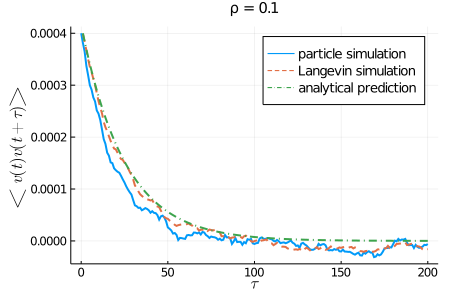

In [15]:
title = "ρ = "*string(round(thermVals["ρ"],digits=2))
p2 = plot(timesCorrP_t, vCorrPar_t, label="particle simulation", 
    size=(450,300),
    linewidth=2,
    titlefontsize=10,
    legendfontsize=9,
    dpi=100)
plot!(timesCorrL_t, vCorrLan_t, 
    linewidth=2,
    linestyle=:dash,
    label="Langevin simulation")
plot!(timesCorrL_t, vCorrPred_t,
    linewidth=2,
    linestyle=:dashdot,
    label="analytical prediction")
xlabel!(L"\tau")
ylabel!(L"\left< v(t)v(t+\tau) \right>")
title!(title)
display(p2)

# savefig(p2, "../Figures/fixedDensity_velautocorr_rho"*string(round(thermVals["ρ"],digits=2))*".pdf")


Mean squared displacement:

In [17]:
msdTimes = (waitTime, evolveTime)
timesLMSD_t, msdLan_t = Theorist.msd(langevinEnsemble, arenaParams,  msdTimes);
timesPMSD_t = msdTimes[1]:msdTimes[2]
msdPar_t = BParts.meanSquaredDisplacement(pos_t_dim_id, msdTimes);


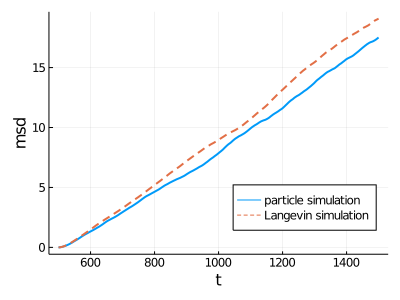

In [18]:
p2 = plot(timesPMSD_t, msdPar_t, label="particle simulation", linewidth=2, 
    legend=:bottomright, size=(400,300))
plot!(timesLMSD_t, msdLan_t, label="Langevin simulation", linewidth=2, linestyle=:dash)
xlabel!("t")
ylabel!("msd")
display(p2)

# savefig(p2, "../Figures/fixedDensity_msd.pdf")


## MSD for different densities
As the density of the system increases, cells undergo more collisions, thus we predict the MSD to decrease as the density increase. Note that becuase the cells are spatially constrained the MSD must converge to a maximum value determined by the system's size.

In [11]:
sDensity(n0, r, V) = n0*π*r^2 / V

sDensity (generic function with 1 method)

In [12]:
nSims = 50

arenaParams2 = 
    Dict(
        "n0"=> 1,
        "evolveTime"=> 1500,
        "timeStep"=> 0.08,
        "bounds"=>((0.,10.),(0.,10.)), 
        "radius"=>0.08, 
        "speed"=>0.03
    )
extendParams!(arenaParams2)

waitTime = 500
evolveTime = arenaParams2["evolveTime"]

# display(arenaParams2)
n0_sim = [100, 200, 400, 800]
dens_sim = sDensity.(n0_sim, arenaParams2["radius"], arenaParams2["volume"])

4-element Array{Float64,1}:
 0.02010619298297468
 0.04021238596594936
 0.08042477193189872
 0.16084954386379743

In [13]:
# ===== Multiple Parameter sets =====
params_dens = Array{Dict}(undef, length(n0_sim))
for (i,n0) in enumerate(n0_sim)
    params_dens[i] = copy(arenaParams2)
    params_dens[i]["n0"] = n0
    extendParams!(params_dens[i])
end

In [14]:
# ===== Multiple Particle simulations =====

pos_Dens_Sim_t_dim_id = Array{Array{Array{Union{Float64, Missing},3}}}(undef, length(n0_sim))
@showprogress for (d, n0) in enumerate(n0_sim)
    
    arenaParams2["n0"] = n0
    pos_Sim = Array{Array{Union{Float64, Missing},3}}(undef, nSims)
    for i in 1:nSims
        succes = false
        while !succes 
            # try/catch construction in case boundserror occurs
            try
                _, posSim_t_dim_id, __, ___ = 
                    BParts.randArenaEvolve(arenaParams2["n0"], 
                        arenaParams2["evolveTime"], 
                        arenaParams2["timeStep"], 
                        arenaParams2;
                        progress=false, verbose=false)
                pos_Sim[i] = posSim_t_dim_id
    #             println("sim: ", i)
            catch e
                println("fail")
                continue 
            end
            succes = true
        end
    end
    pos_Dens_Sim_t_dim_id[d] = pos_Sim
end

Progress:  75%|██████████████████████████████▊          |  ETA: 0:21:46

fail


Progress: 100%|█████████████████████████████████████████| Time: 3:52:07


In [15]:
# ===== Multiple Langevin simulations =====

lEnsSim_Dens = []

for (d, n0) in enumerate(n0_sim)
    arenaParams2["n0"] = n0
    extendParams!(arenaParams2)
    @time langevinEnsembleSim = Theorist.runLangevinSims(5000, arenaParams2)
    push!(lEnsSim_Dens, langevinEnsembleSim)
    
end

Energy: 0.00045
 63.729671 seconds (1.76 G allocations: 27.205 GiB, 27.52% gc time)
Energy: 0.00045
118.888768 seconds (1.76 G allocations: 27.205 GiB, 33.28% gc time)
Energy: 0.00045
 84.361270 seconds (1.76 G allocations: 27.205 GiB, 39.27% gc time)
Energy: 0.00045
 94.216113 seconds (1.88 G allocations: 28.993 GiB, 44.40% gc time)


In [16]:
# ===== MSD Particle simulations =====

msdTimes = (waitTime, evolveTime)
timesPMSD_t = msdTimes[1]:msdTimes[2]

msd_Dens_t = Array{Float64}[]
for j in 1:length(n0_sim)
    
    msd_Sim = Array{Array{Float64}}(undef, nSims)
    @showprogress for i in 1:nSims
        msd_Sim[i] = BParts.meanSquaredDisplacement(pos_Dens_Sim_t_dim_id[j][i], msdTimes)
    end
    
    msdAv_t = Array{Float64, 1}(undef, length(timesPMSD_t))
    for i in 1:length(timesPMSD_t)
        msdAv_t[i] = mean([ msd_tt[i] for msd_tt in msd_Sim ])
    end
    push!(msd_Dens_t, msdAv_t)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


In [17]:
# ===== MSD theory =====

function msdTheory(t, E, γ)
    4 * (E / γ)*(  t - ( 1 - exp(-γ*t) )/γ  )
end

msdTheory_t = (t -> msdTheory(t, thermVals["E"], thermVals["γ"])).(timesPMSD_t.-timesPMSD_t[1]);

In [18]:
# ===== MSD Langevin simulations =====

msdL_Dens_t = Array{Float64}[]
msdLT_Dens_t = Array{Float64}[]
@showprogress for j in 1:length(n0_sim)
    
    @time timesLMSD_t, msdLan_t = Theorist.msd(lEnsSim_Dens[j], arenaParams2,  msdTimes)
    push!(msdL_Dens_t, msdLan_t)
    
    thermVals2 = Theorist.thermalValues(params_dens[j])
    msdLTheory_t = (t -> msdTheory(t, thermVals2["E"], thermVals2["γ"])).(timesPMSD_t.-timesPMSD_t[1]);
    push!(msdLT_Dens_t, msdLTheory_t)
    
end

 30.153613 seconds (51.01 M allocations: 2.779 GiB, 77.99% gc time)


Progress:  50%|████████████████████▌                    |  ETA: 0:00:40

  9.634902 seconds (49.73 M allocations: 2.717 GiB, 48.63% gc time)


Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:16

  7.214843 seconds (49.73 M allocations: 2.717 GiB, 37.49% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


  8.230621 seconds (49.73 M allocations: 2.717 GiB, 47.69% gc time)


In [19]:
msdLT_Dens_t = Array{Float64}[]
for j in 1:length(n0_sim)
    
    thermVals2 = Theorist.thermalValues(params_dens[j])
    msdLTheory_t = (t -> msdTheory(t, thermVals2["E"], thermVals2["γ"])).(timesPMSD_t.-timesPMSD_t[1]);
    push!(msdLT_Dens_t, msdLTheory_t)
    
end

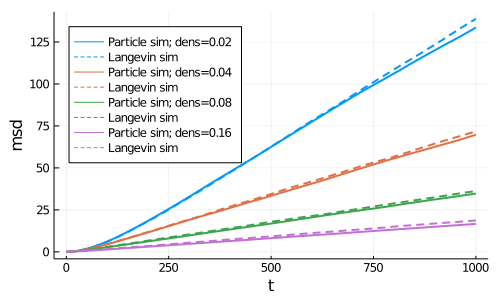

In [20]:
p2 = plot(timesPMSD_t.-timesPMSD_t[1], msd_Dens_t[1], label="Particle sim; dens="*string(round(dens_sim[1], digits=2)), linewidth=2, 
    legend=:topleft, size=(500,300), color=1)
plot!(timesPMSD_t.-timesPMSD_t[1], msdL_Dens_t[1], label="Langevin sim", linewidth=2, linestyle=:dash, color=1)
# plot!(timesPMSD_t, msdLT_Dens_t[1], label="Langevin Integral", linewidth=2, linestyle=:dashdot, color=1)
for i in 2:length(n0_sim)
    plot!(timesPMSD_t.-timesPMSD_t[1], msd_Dens_t[i], label="Particle sim; dens="*string(round(dens_sim[i], digits=2)), linewidth=2, color=i)
    plot!(timesPMSD_t.-timesPMSD_t[1], msdL_Dens_t[i], label="Langevin sim", linewidth=2, linestyle=:dash, color=i)
#     plot!(timesPMSD_t, msdLT_Dens_t[i], label="Langevin integral", linewidth=2, linestyle=:dashdot, color=i)
end
xlabel!("t")
ylabel!("msd")
display(p2)

# savefig(p2, "../Figures/multFixedDensity_msd_s"*string(arenaParams2["speed"])*".pdf")

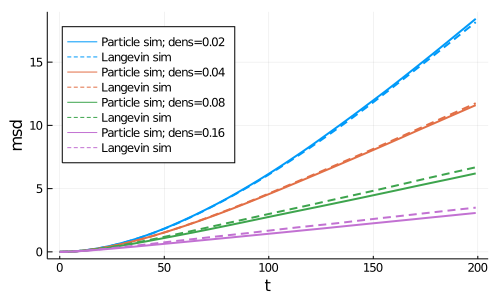

In [21]:
p2 = plot((timesPMSD_t.-timesPMSD_t[1])[1:200], msd_Dens_t[1][1:200], label="Particle sim; dens="*string(round(dens_sim[1], digits=2)), linewidth=2, 
    legend=:topleft, size=(500,300), color=1)
plot!((timesPMSD_t.-timesPMSD_t[1])[1:200], msdL_Dens_t[1][1:200], label="Langevin sim", linewidth=2, linestyle=:dash, color=1)
# plot!(timesPMSD_t, msdLT_Dens_t[1], label="Langevin Integral", linewidth=2, linestyle=:dashdot, color=1)
for i in 2:length(n0_sim)
    plot!((timesPMSD_t.-timesPMSD_t[1])[1:200], msd_Dens_t[i][1:200], label="Particle sim; dens="*string(round(dens_sim[i], digits=2)), linewidth=2, color=i)
    plot!((timesPMSD_t.-timesPMSD_t[1])[1:200], msdL_Dens_t[i][1:200], label="Langevin sim", linewidth=2, linestyle=:dash, color=i)
#     plot!(timesPMSD_t, msdLT_Dens_t[i], label="Langevin integral", linewidth=2, linestyle=:dashdot, color=i)
end
xlabel!("t")
ylabel!("msd")
display(p2)

In [22]:
?SRIW1

search: SRIW1 constructSRIW1 SRIW2



No documentation found.

# Summary

```
struct SRIW1 <: StochasticDiffEqAdaptiveAlgorithm
```

# Supertype Hierarchy

```
SRIW1 <: StochasticDiffEqAdaptiveAlgorithm <: StochasticDiffEqAlgorithm <: DiffEqBase.AbstractSDEAlgorithm <: DiffEqBase.DEAlgorithm <: Any
```
